In [2]:
import os
from itertools import product
from collections import namedtuple
import time
from typing import Tuple
import random

from tabulate import tabulate
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
import numpy as np
import pandas as pd

# Подключаем локальные пакеты
from pyqumo.random import Distribution, Exponential, HyperExponential, Erlang
from pyqumo.cqumo.sim import simulate_tandem


from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2, get_noncentral_m3
from pyqumo.random import HyperErlang

# Поключаем пакеты для ML
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.python.keras import engine
from tensorflow.keras import layers
import seaborn as sns
from scipy import stats

In [3]:
# Настраиваем matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})
# matplotlib.rcParams.update({'font.weight': 'bold'})

In [4]:
pd.options.mode.chained_assignment = None
data = pd.read_csv('data/Tandem_network_with_m_ph_1_n_distribution_100k.csv', index_col='Id')

COLUMNS = (
    'ArrAvg',
    'SrvAvg', 
    'SrvStd', 
    'SrvCv',
    'SrvSkewness', 
    'NetSize',
)

In [5]:
data.describe()

,ArrM1,ArrAvg,SrvM1,SrvM2,SrvM3,SrvAvg,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
count,110020.000000,110020.000000,110020.000000,1.100200e+05,1.100200e+05,110020.000000,110020.000000,110020.000000,110020.000000,110020.000000,110020.000000,110020.000000,110020.0,110020.000000,110020.000000,110020.000000
mean,0.030034,0.030034,0.000350,5.294636e-06,1.041493e-06,0.000350,0.002177,6.227383,78.062591,0.145007,10.481694,499.956372,100000.0,0.077326,0.203237,0.991881
std,0.011563,0.011563,0.000087,3.092637e-06,1.164804e-06,0.000087,0.000654,1.026603,41.521255,0.118750,5.771131,4.576017,0.0,0.118438,0.240203,0.023680
min,0.010000,0.010000,0.000200,8.439018e-07,4.571082e-09,0.000200,0.000896,4.450046,4.393383,0.004000,1.000000,20.000000,100000.0,0.000206,0.000735,0.548374
25%,0.019996,0.019996,0.000274,2.848736e-06,2.610705e-07,0.000274,0.001663,5.334189,42.049620,0.059508,5.000000,500.000000,100000.0,0.006478,0.037298,0.996266
50%,0.030066,0.030066,0.000349,4.602210e-06,6.187726e-07,0.000349,0.002114,6.230684,78.214354,0.115587,10.000000,500.000000,100000.0,0.032394,0.120856,1.000000
75%,0.040082,0.040082,0.000424,7.089538e-06,1.380167e-06,0.000424,0.002631,7.116858,113.911863,0.193961,15.000000,500.000000,100000.0,0.099111,0.283770,1.000000
max,0.050000,0.050000,0.000500,1.623478e-05,9.401572e-06,0.000500,0.003998,7.999956,149.995002,0.929074,20.000000,500.000000,100000.0,1.987695,5.418271,1.000000


In [48]:
simulation_data = data[data['DelayAvg']<.1]

In [49]:
# simulation_data = data

In [50]:
simulation_data['DelayAvg']

Id
0         0.007580
1         0.014736
2         0.026902
3         0.048612
4         0.021808
            ...   
110014    0.098237
110015    0.000560
110016    0.073102
110017    0.001270
110018    0.065056
Name: DelayAvg, Length: 82761, dtype: float64

In [51]:
# simulation_data['DelayAvg'] = simulation_data['DelayAvg']*1000
# simulation_data['DelayAvg']
# simulation_data

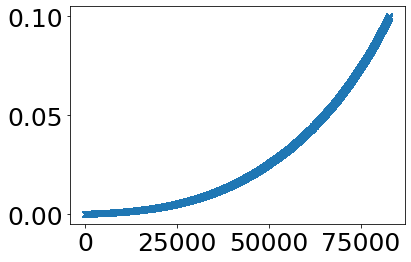

In [52]:
plt.plot(np.sort(simulation_data['DelayAvg']), 'x')

In [53]:
simulation_data[simulation_data['NetSize']==20]

,ArrM1,ArrAvg,SrvM1,SrvM2,SrvM3,SrvAvg,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
Id,,,,,,,,,,,,,,,,
67,0.047554,0.047554,0.000470,0.000006,1.387012e-06,0.000470,0.002359,5.014229,105.056965,0.190083,20.0,500.0,100000.0,0.051008,0.198272,1.000000
120,0.040525,0.040525,0.000285,0.000004,9.475818e-07,0.000285,0.001922,6.754516,133.073616,0.137483,20.0,500.0,100000.0,0.040708,0.167483,0.997090
138,0.022659,0.022659,0.000290,0.000003,6.793573e-07,0.000290,0.001796,6.185050,116.807087,0.241796,20.0,500.0,100000.0,0.056133,0.229168,0.985401
186,0.047863,0.047863,0.000341,0.000004,5.833612e-07,0.000341,0.001932,5.667706,80.337835,0.140033,20.0,500.0,100000.0,0.098291,0.351623,0.993222
246,0.024911,0.024911,0.000232,0.000001,9.447116e-08,0.000232,0.001081,4.661098,74.151056,0.184949,20.0,500.0,100000.0,0.048453,0.165612,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109537,0.045484,0.045484,0.000253,0.000004,7.662403e-07,0.000253,0.001941,7.685177,104.469326,0.107215,20.0,500.0,100000.0,0.053919,0.217357,0.994649
109671,0.017084,0.017084,0.000228,0.000002,1.291444e-07,0.000228,0.001271,5.581185,62.297603,0.264902,20.0,500.0,100000.0,0.080336,0.175060,0.992783
109744,0.049086,0.049086,0.000229,0.000003,5.110536e-07,0.000229,0.001660,7.232390,111.386036,0.091065,20.0,500.0,100000.0,0.050434,0.276858,0.994844


In [54]:
# simulation_data[simulation_data['Rho']>.9]

In [55]:
train_data, test_data, y_train, y_test = train_test_split(
    simulation_data, simulation_data.loc[:, ['DelayAvg', 'DeliveryProb']], 
    test_size=0.33, 
    random_state=42)
x_train = train_data.loc[:, COLUMNS]
x_test = test_data.loc[:, COLUMNS]

### МЕТРИКИ
Для оценки полученных моделей нам будут необходимы метрики, а именно:

- Стандартное отклонение

In [56]:
def std(x: np.ndarray, y: np.ndarray) -> float:
    """
    Standard deviation between simulation model 
    values and estimates
    """
    return math.sqrt(np.sum((x-y)**2) / (len(x) - 1))

- Коэффициент корреляции

In [57]:
def corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation coefficient between simulation model 
    values and estimate 
    """
    r = np.corrcoef(x, y)
    return r[0,1]

- среднеквадратичная ошибка;

```sklearn.metrics.mean_squared_error ```;
- и коэффициент детерминации.

```sklearn.metrics.r2_score```.

### Приступим непосредственно к обучению

-  ## Задача регресии МНК

In [58]:
"""Prepare regression model using Least Squares algorithm"""
def get_ls_regression_model(x_train, x_test, 
                            y_train, y_test) -> (np.ndarray, LinearRegression):
    ls = LinearRegression()
    # ls = Ridge(alpha=.5)
    ls.fit(x_train, y_train)
    ls_y = ls.predict(x_test)

    return ls_y, ls

In [59]:
ls_delay_estimate, ls = get_ls_regression_model(x_train, x_test, 
                                                y_train['DelayAvg'], 
                                                y_test['DelayAvg'])

In [60]:
print(f'R = {corr(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'STD = {std(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], ls_delay_estimate):.3f}')

R = 0.859
STD = 0.014
MSE = 0.000
R2 = 0.738
MAPE = 3.712


In [61]:
# DataFrame для отриосвки графиков
draw_data = test_data
draw_data.loc[:,'DelayAvgTest'] = y_test.loc[:,'DelayAvg']
draw_data.loc[:, 'LsDelayEst'] = ls_delay_estimate

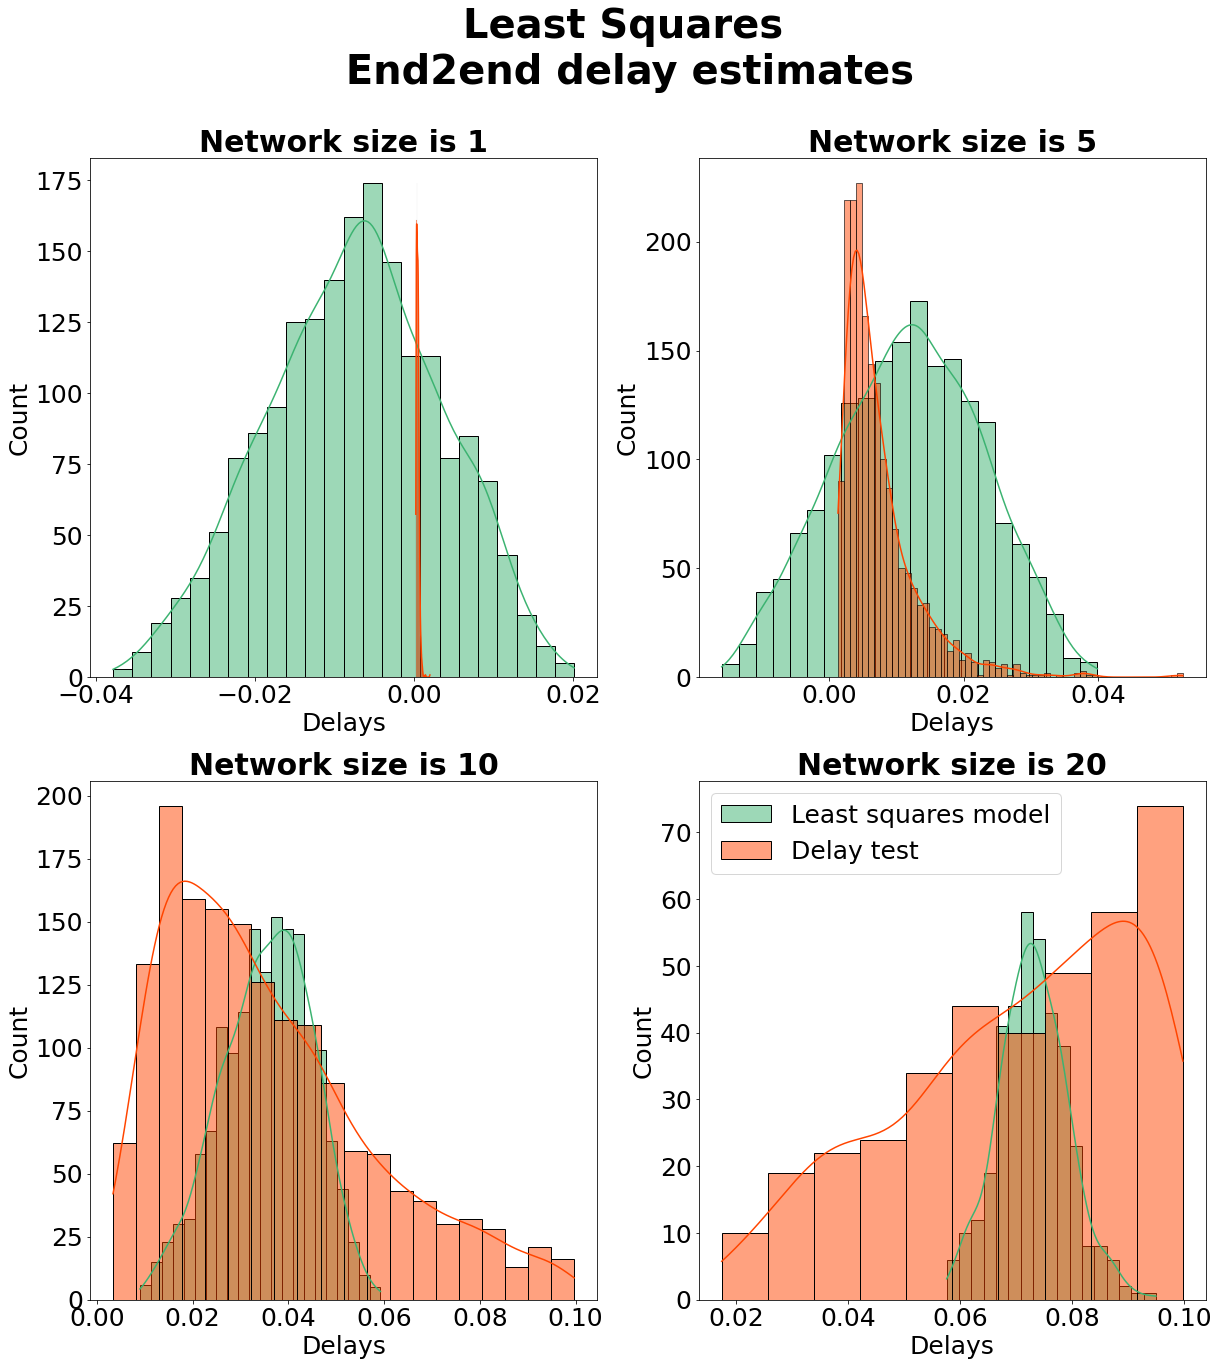

In [62]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('Least Squares \n End2end delay estimates \n', 
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Network size is ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'LsDelayEst'], 
                          color="mediumseagreen", 
                          label="Least squares model", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Delay test", kde=True)
        
        k += 1
        plt.xlabel('Delays')
plt.legend()
plt.savefig('data/m_ph_images/ls_histogram.png')

-  ## Задача регресии на дереве решений

In [63]:
"""Prepare regression model using Decision Tree algorithm"""
def get_tree_regression_model(x_train, x_test, 
                              y_train, y_test, 
                              max_depth=30, 
                              splitter='best') -> (np.ndarray, DecisionTreeRegressor):
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, splitter=splitter, 
                                     criterion='mse')
    tree_reg.fit(x_train, y_train)
    tree_y = tree_reg.predict(x_test)
    
    # print(f'R = {corr(y_test, tree_y):.3f}')
    # print(f'STD = {std(y_test, tree_y):.3f}')
    # print(f'MSE = {mean_squared_error(y_test, tree_y):.3f}')

    return tree_y, tree_reg

In [64]:
tree_delay_estimate, tree_reg = get_tree_regression_model(x_train, x_test, 
                                                        y_train['DelayAvg'], 
                                                        y_test['DelayAvg'])

In [65]:
print(f'R = {corr(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'STD = {std(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], tree_delay_estimate):.3f}')

R = 0.868
STD = 0.014
MSE = 0.000
R2 = 0.736
MAPE = 0.319


In [66]:
draw_data.loc[:, 'TreeDelayEst'] = tree_delay_estimate 

In [67]:
draw_data.loc[:, 'TreeDelayEst'].describe()

count    27312.000000
mean         0.027086
std          0.027762
min          0.000206
25%          0.003599
50%          0.016352
75%          0.044435
max          0.099982
Name: TreeDelayEst, dtype: float64

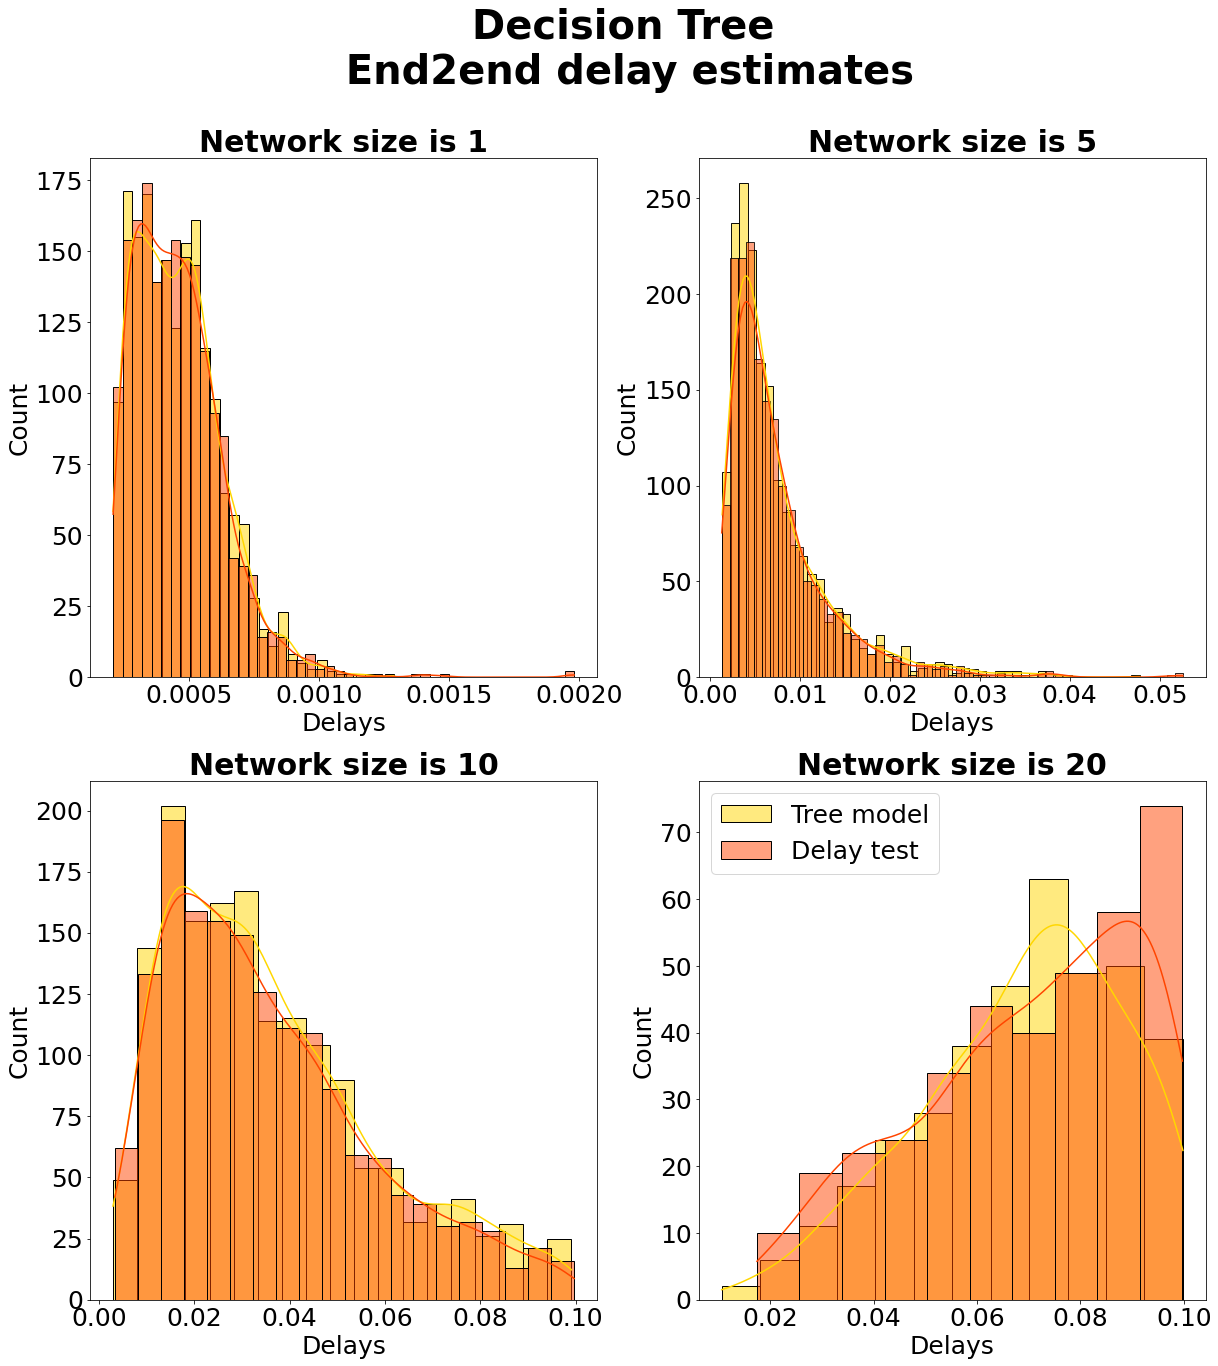

In [68]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('Decision Tree \n End2end delay estimates \n', 
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
#     size = [3, 8, 11, 15]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Network size is ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'TreeDelayEst'], 
                          color="gold", 
                          label="Tree model", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Delay test", kde=True)
        
        k += 1
        plt.xlabel('Delays')
plt.legend()
plt.savefig('data/m_ph_images/tree_histogram.png')

(0.3, 1.0)

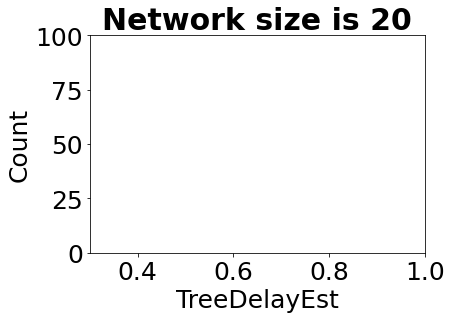

In [69]:
draw_hist = draw_data

plt.title('Network size is ' + str(int(i)), fontweight='bold')
ax = sns.histplot(draw_hist.loc[:,'TreeDelayEst'], 
                  color="gold", 
                  label="Tree model", kde=True)
ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Delay test", kde=True)
plt.ylim([0, 100])
plt.xlim([0.3, 1])

-  ## Задача регрессии с помощью градиентного бустинга на деревьях решений

In [70]:
"""Prepare regression model using Gradient Boosting algorithm"""
def get_gtb_regression_model(x_train, x_test, 
                             y_train, y_test, 
                             n_estimators=100, 
                             learning_rate=.001,
                             max_depth=18) -> (np.ndarray, GradientBoostingRegressor):
    gtb = GradientBoostingRegressor(n_estimators=n_estimators, 
                                    learning_rate=learning_rate, 
                                    max_depth=max_depth)
    gtb.fit(x_train, y_train)
    gtb_y = gtb.predict(x_test)

    return gtb_y, gtb

In [71]:
gtb_delay_estimate, gtb = get_tree_regression_model(x_train, x_test, 
                                               y_train['DelayAvg'], 
                                               y_test['DelayAvg'])

In [72]:
print(f'R = {corr(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'STD = {std(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], gtb_delay_estimate):.3f}')

R = 0.866
STD = 0.014
MSE = 0.000
R2 = 0.732
MAPE = 0.321


In [73]:
draw_data.loc[:, 'GTBDelayEst'] = gtb_delay_estimate 

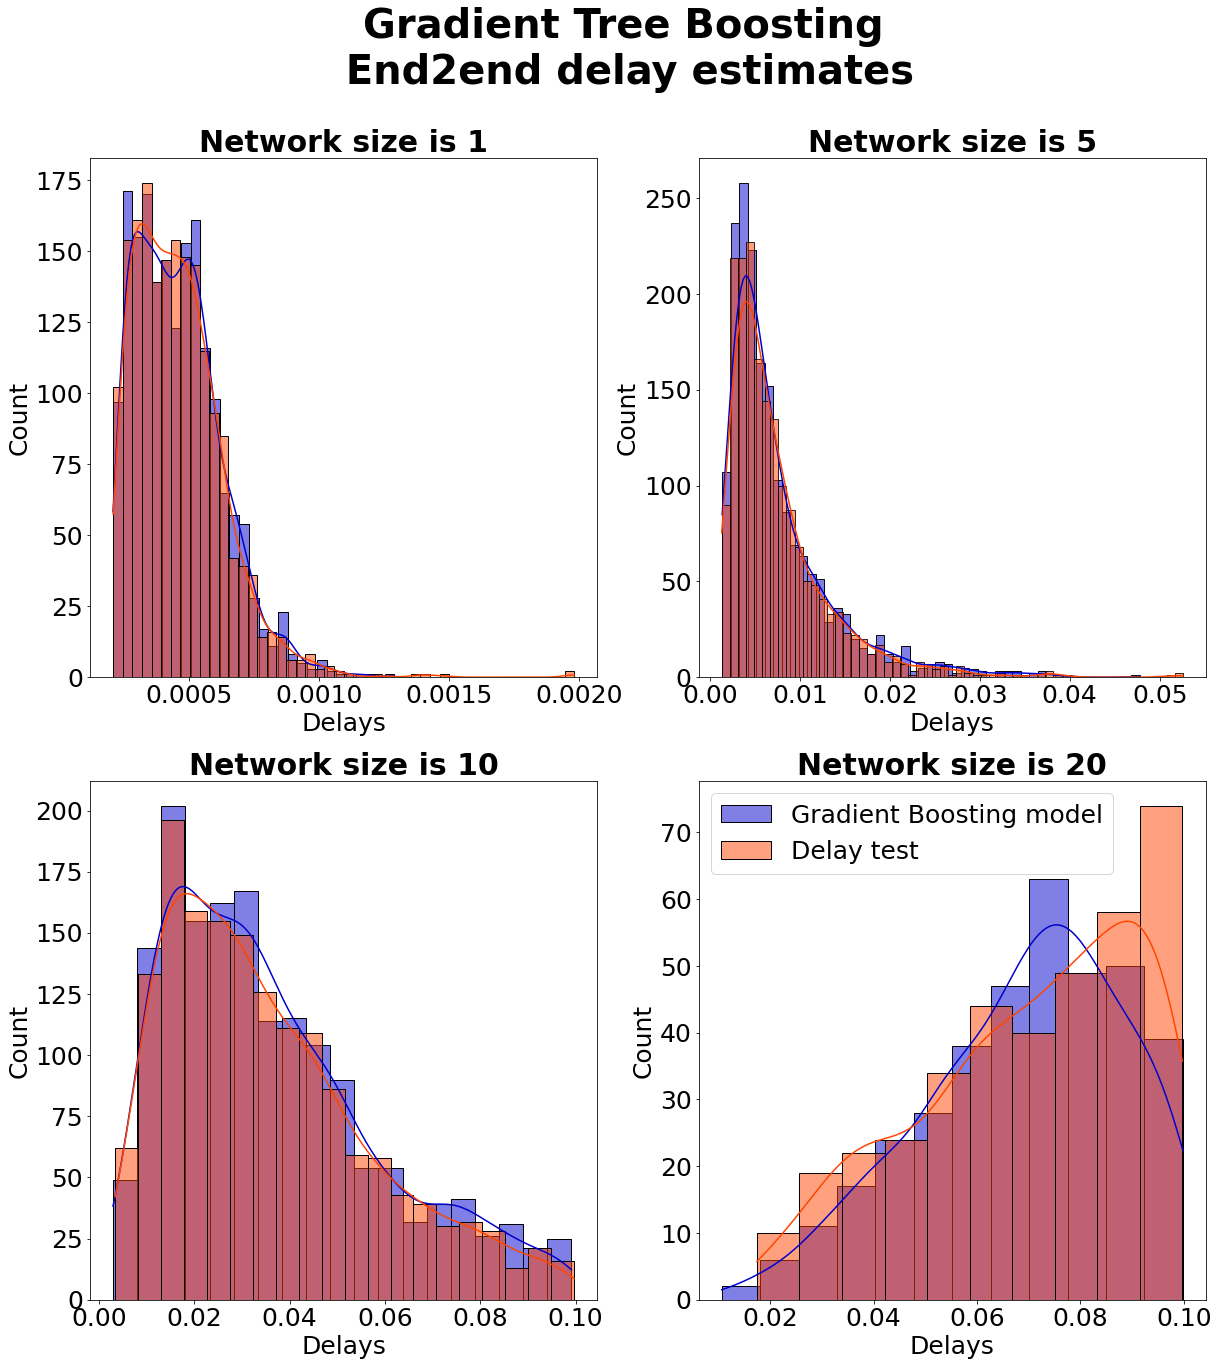

In [74]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('Gradient Tree Boosting \n End2end delay estimates \n', 
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Network size is ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'TreeDelayEst'], 
                          color="mediumblue", 
                          label="Gradient Boosting model", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Delay test", kde=True)
        
        
        k += 1
        plt.xlabel('Delays')
plt.legend()
plt.savefig('data/m_ph_images/gtb_histogram.png')

-  ## Задача регрессии с помощью искуственной нейронной сети на алгоритме Adam

In [75]:
def normalize(table, stat) -> pd.core.frame.DataFrame:
    """Prepare data for ANN"""
    return (table - stat.loc['mean',:].transpose()) / stat.loc['std',:].transpose()

In [76]:
train_normalize = normalize(x_train, simulation_data.loc[:,COLUMNS].describe())
train_normalize.to_numpy();
test_normalize = normalize(x_test, simulation_data.loc[:,COLUMNS].describe())
test_normalize.to_numpy();

In [77]:
train_normalize

,ArrAvg,SrvAvg,SrvStd,SrvCv,SrvSkewness,NetSize
Id,,,,,,
15364,0.909100,0.421488,0.106567,-0.413165,0.185480,-0.091948
11608,-1.526281,-0.488755,-0.745455,-0.706255,-1.167871,-0.886527
5974,0.728971,1.234725,0.000674,-1.440401,0.332396,1.099922
14334,0.057575,-0.161675,0.051932,0.349447,-0.316564,1.298567
20670,0.455529,0.094156,0.212357,0.230447,-0.237477,0.901277
...,...,...,...,...,...,...
8301,-1.330067,-0.262882,-0.782236,-1.104910,-1.488687,-0.091948
73073,1.419386,-0.850218,-0.649639,0.140150,0.549545,2.291791
102139,-1.229329,-0.687859,-0.683625,-0.243488,1.539166,1.298567


In [79]:
def build_model(size, activation='sigmoid') -> np.ndarray:
    model = keras.Sequential([
        # Input Layer
#         layers.Dense(18, activation=activation, 
#                      use_bias=True, input_shape=[size]),
        layers.Flatten(input_shape=[size]),
        # Hidden Layer
#         layers.Dense(120, activation=activation),
        layers.Dense(120, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
        
        # Output layer
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    print(model.summary())
    return model


def get_ann_regression_model(train_normalize, 
                             test_normalize, 
                             y_train_ann, y_test_ann, 
                             size,
                             epochs=1000,
                             activation='sigmoid') -> Tuple[np.ndarray, 
                                                            engine.sequential.Sequential]:
    
    ann = build_model(size=size)
   
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    EPOCHS = epochs
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    ann.fit(train_normalize, y_train_ann, epochs=EPOCHS, validation_split=0.3, verbose=0, 
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

    ann_y = ann.predict(test_normalize).flatten();
    
    return ann_y, ann


In [80]:
%%time
ann_delay_estimate, ann = get_ann_regression_model(train_normalize, test_normalize,
                                                   y_train['DelayAvg'], y_test['DelayAvg'],
                                                   size=len(simulation_data.loc[:,COLUMNS].keys()),
                                                   activation='sigmoid')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 120)               840       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 121       
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 26.4 s, sys: 4.07 s, total: 30.5 s
Wall time: 16.5 s


In [81]:
print(f'R = {corr(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'STD = {std(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], ann_delay_estimate):.3f}')

R = 0.921
STD = 0.013
MSE = 0.000
R2 = 0.797
MAPE = 2.099


In [82]:
# Добавим в draw_data оценку ann_y 
draw_data['AnnDelayEst'] = ann_delay_estimate

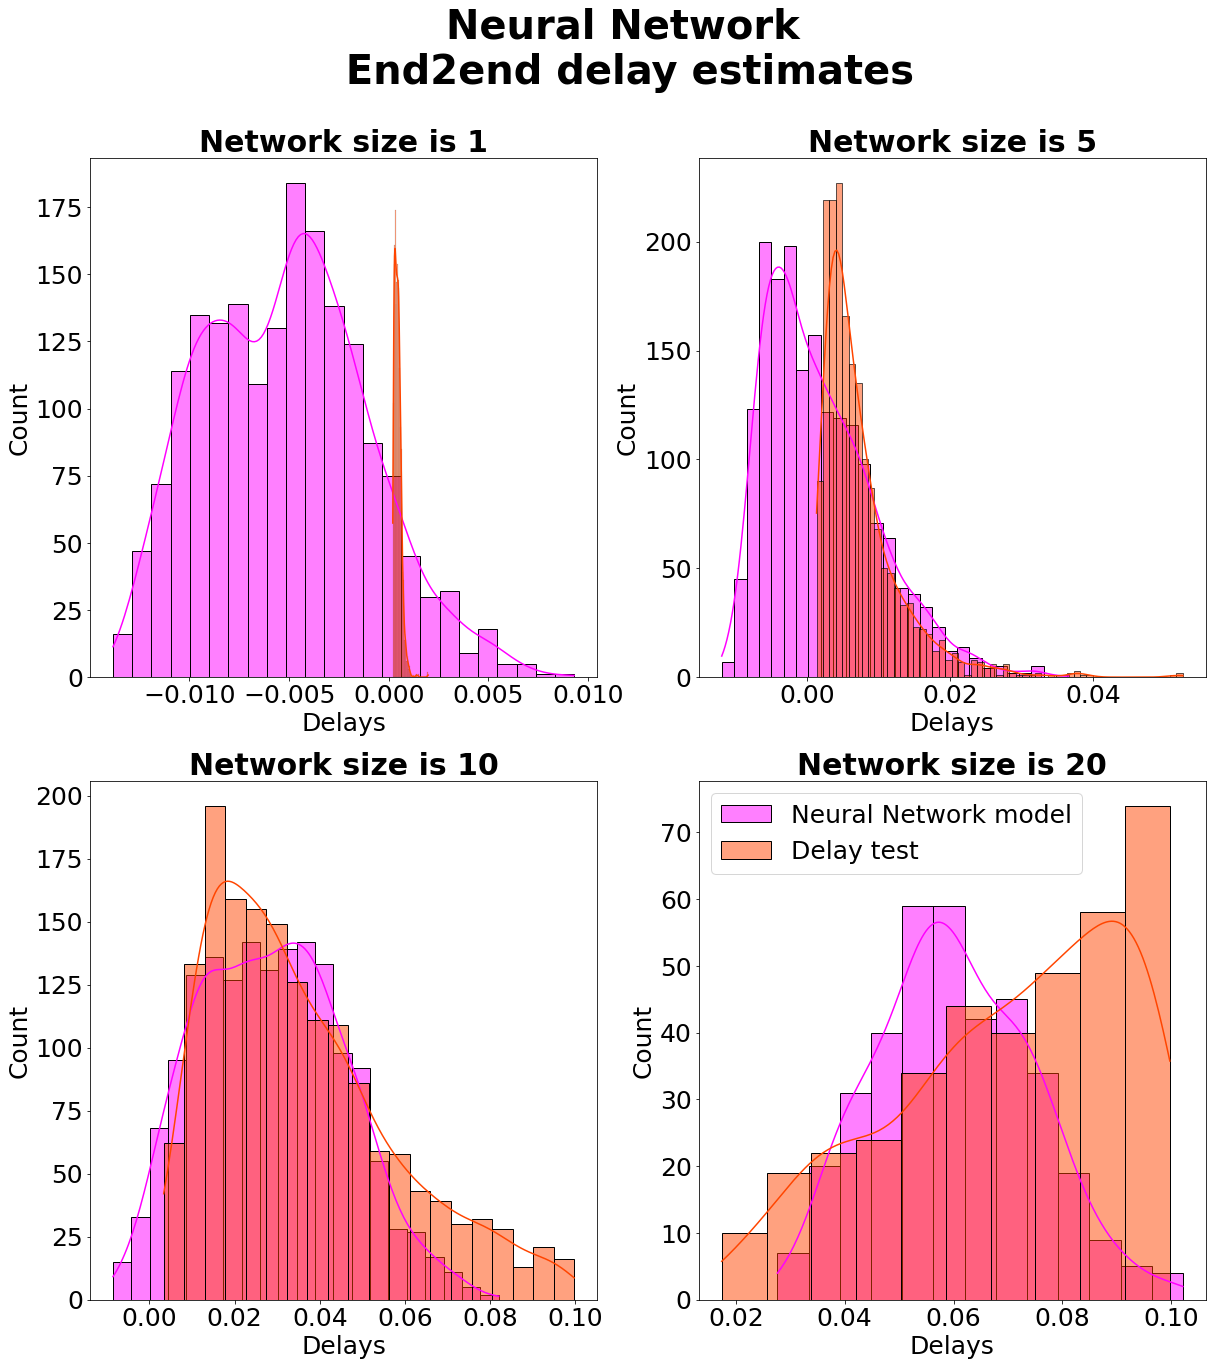

In [83]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('Neural Network \n End2end delay estimates \n', 
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Network size is ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'AnnDelayEst'], 
                          color="fuchsia", 
                          label="Neural Network model", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Delay test", kde=True)
        
        
        k += 1
        plt.xlabel('Delays')
plt.legend()
plt.savefig('data/m_ph_images/ann_histogram.png')

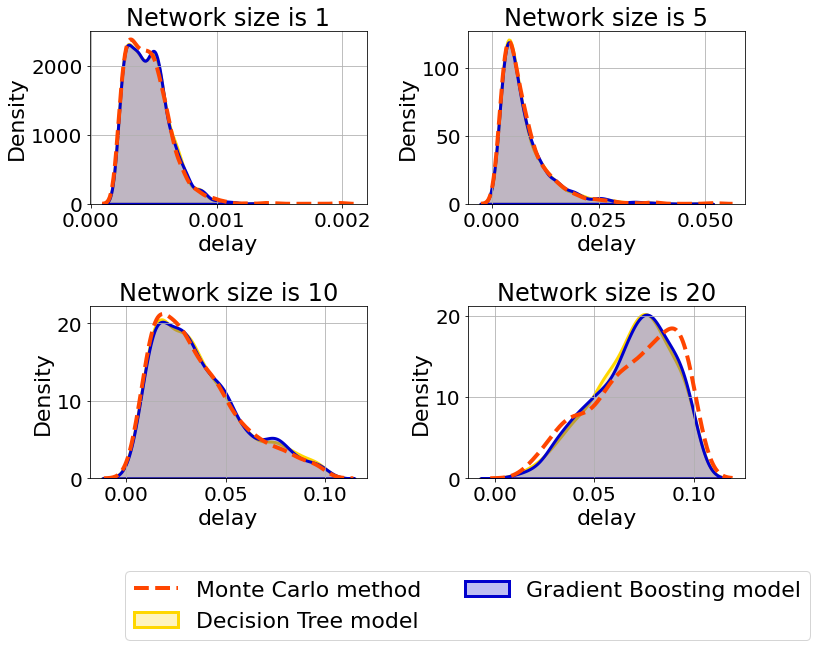

In [84]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(11, 8))

k = 1
for i in net_size:
    size = [1, 5, 10, 20]
    # size = [i for i in range(21)]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Network size is ' + str(int(i)), fontsize='24')
#         ax = sns.kdeplot(draw_hist.loc[:,'AnnDelayEst'], 
#                           color="fuchsia", shade=True, linewidth=3,
#                           label="Neural Network model")
#         ax = sns.kdeplot(draw_hist.loc[:,'LsDelayEst'], 
#                          color="limegreen", shade=True, linewidth=3,
#                          label="Least Squares model")
        ax = sns.kdeplot(draw_hist.loc[:,'TreeDelayEst'], 
                          color="gold", shade=True, linewidth=3,
                          label="Decision Tree model")
        ax = sns.kdeplot(draw_hist.loc[:,'GTBDelayEst'], 
                          color="mediumblue", shade=True, linewidth=3,
                          label="Gradient Boosting model")
        ax = sns.kdeplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", linewidth=4, linestyle='--',
                          label="Monte Carlo method")
        plt.grid()
        k += 1
    plt.xlabel('delay',fontsize='22')
    plt.ylabel('Density', fontsize='22')
    plt.xticks(fontsize='20')
    plt.yticks(fontsize='20')    
    fig.tight_layout()

ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0, -1), prop={'size': 22})
plt.savefig('data/m_ph_images/delay_estimate_densities.png', bbox_inches = 'tight')

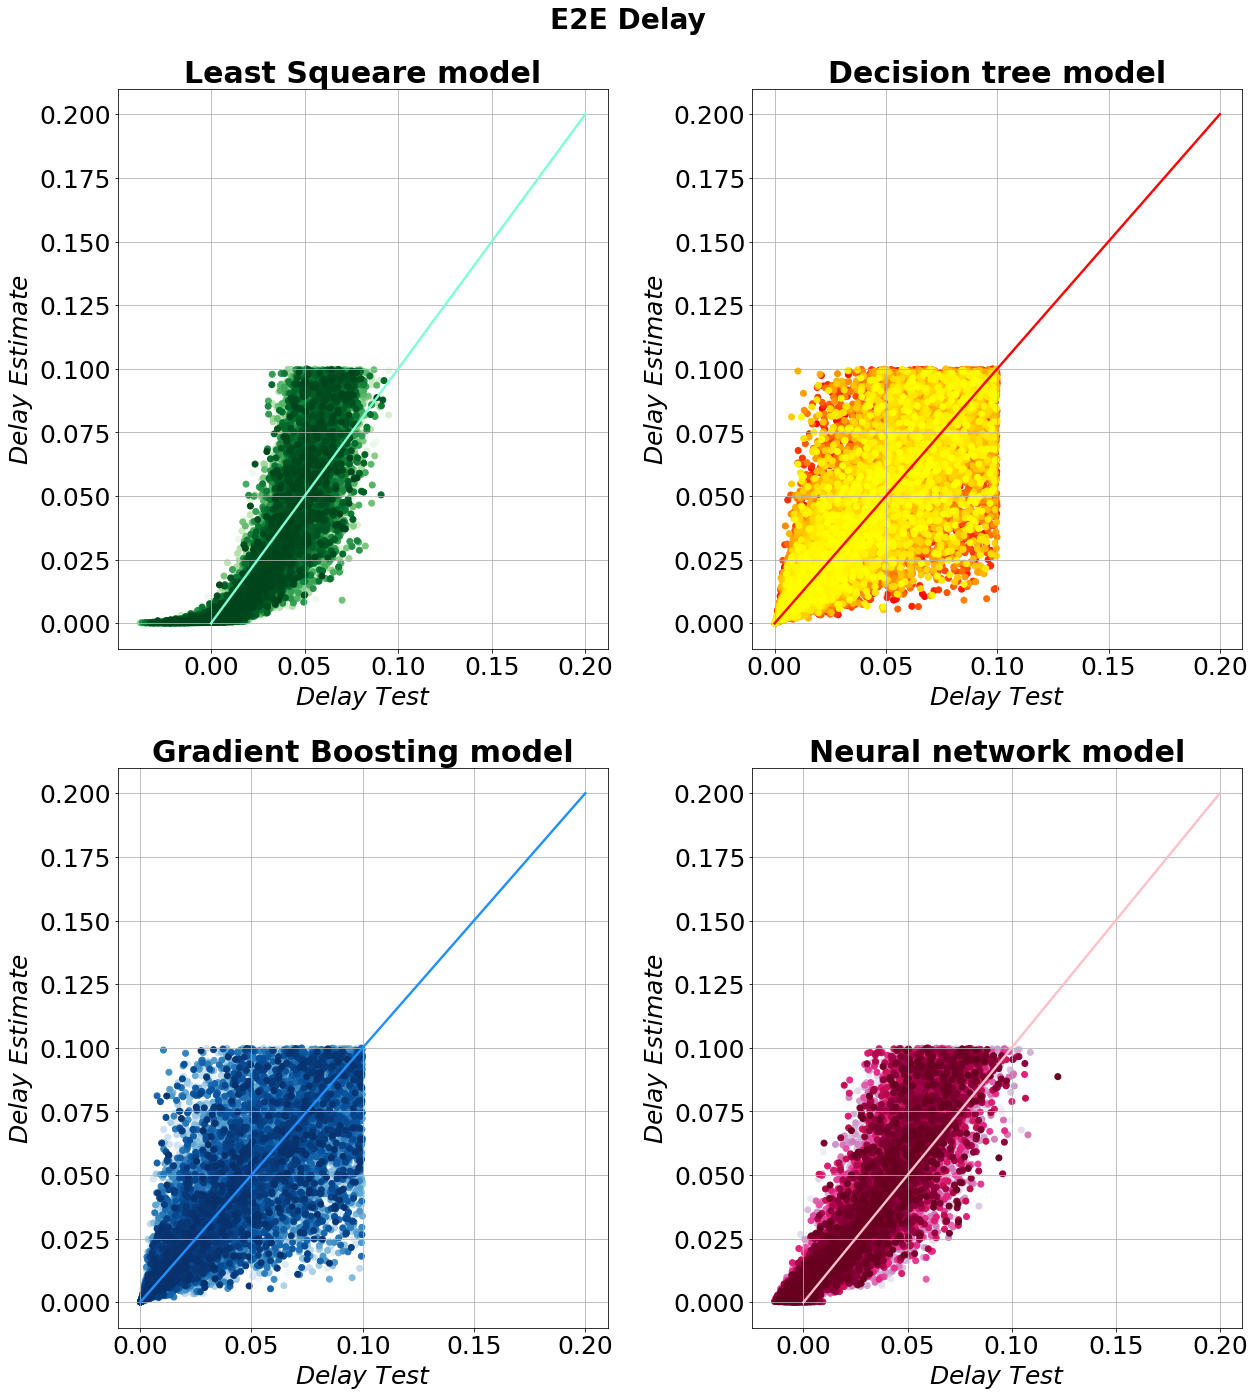

In [85]:
model = [ls_delay_estimate, 
         tree_delay_estimate,
         gtb_delay_estimate,
         ann_delay_estimate]

label = ['Least Squeare model',
         'Decision tree model',
         'Gradient Boosting model',
         'Neural network model']
column = ['LsDelayEst',
          'TreeDelayEst',
          'GTBDelayEst',
          'AnnDelayEst']
scatter_color = ['Greens',
                 'autumn',
                 'Blues',
                 'PuRd']
diag_line_color = ['aquamarine',         
                   'red',
                   'dodgerblue',
                   'pink']
simulation_data
fig = plt.figure(figsize=(18, 20))
plt.subplots_adjust(top=0.92)
fig.suptitle('E2E Delay', fontsize=28, fontweight='bold')
x = np.linspace(0,.2,100)
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(label[i], fontdict={'fontweight': 'bold'})
    cm = plt.get_cmap(scatter_color[i])
    col = [cm(float(i)/(len(ann_delay_estimate))) for i in range((len(ann_delay_estimate)))]
    ax = plt.scatter(draw_data[column[i]], 
                 draw_data['DelayAvgTest'], 
                 c=col)
#     plt.subplots_adjust(top=0.95)
    plt.plot(x, x, 
             linestyle='-', 
             linewidth=2.4, 
             color=diag_line_color[i])
#     plt.xlim([0, 800])
#     plt.ylim([0, 800])
    plt.xlabel(r'$Delay \ Test$')
    plt.ylabel(r'$Delay \ Estimate$')
    plt.grid()
fig.tight_layout()
plt.savefig('data/m_ph_images/total_scatter_diagram.png')

In [ ]:
draw_data['AnnDelayEst']

In [ ]:

ax = plt.scatter(draw_data[column[3]], 
             draw_data['DelayAvgTest'], 
             c=col)

## ПОСТРОЕНИЕ ПРОГНОЗНОЙ МОДЕЛИ ВЕРОЯТНОСТИ ДОСТАВКИ ПАКЕТОВ В МНОГОФАЗНОЙ СЕТИ МАСОВОГО ОБСЛУЖИВАНИЯ С ЛИНЕЙНОЙ ТОПОЛОГИЕЙ

В отличии от прогнозной модели времени межконцевой задержки, для которой мы строили регрессионную модель, для модели вероятности доставки нам не критично предсказывать конкретные значения. Гораздо важнее оценивать вероятность относительно граничного значения. Мы задаемся граничным условием `BOUNDARY` для условия успешной доставки. 

Будем классификать на две группы:
- успешная доставка P $\in$ \[BOUNDARY, 1];
- вероятность потери пакетов P $\in$  [0, BOUNDARY).

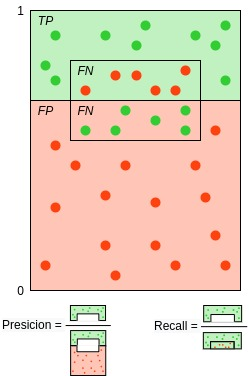

In [35]:
from IPython import display 
display.Image("../experiments/data/images/clf_metrics.jpg")

### Метрики для задач классификации:

_TP_ is true posistive;

_TN_ is true negative;

_FP_ is false positive;

_FN_ is false negative.

Для оценки моделей будем использовать следущие метрики:    
   
$$
    1. \ Precision = \dfrac{TP}{TP + FP};
$$

$$
    2. \ Recall = \dfrac{TP}{TP + FN};
$$

$$
    3. \ F_1 = 2 * \dfrac{Precision * Recall}{Precision + Recall}. 
$$

- ## Модель задачи классификации на Дереве решений

In [36]:
"""Prepare classification model using Decision Tree algorithm"""
def get_tree_classif_model(x_train, x_test, 
                           y_train, y_test, 
                           boundary=0.9, 
                           max_depth=10, 
                           splitter='best') -> Tuple[np.array, 
                                                     DecisionTreeClassifier, 
                                                     list, 
                                                     list]:
    binary_train = [1 if i >= boundary else 0 for i in y_train]
    binary_test = [1 if i >= boundary else 0 for i in y_test]
    clf = DecisionTreeClassifier(max_depth=max_depth, splitter=splitter)
    clf = clf.fit(x_train, binary_train)
    prob_estimate = clf.predict(x_test)
    return prob_estimate, clf, binary_train, binary_test

In [37]:
BOUNDARY = 0.99 
prob_clf_train = [1 if i > BOUNDARY else 0 for i in y_train['DeliveryProb']]
prob_clf_test = [1 if i > BOUNDARY else 0 for i in y_test['DeliveryProb']]

tree_prob_estimate, tree_clf, prob_clf_train, prob_clf_test = get_tree_classif_model(x_train, 
                                                                                     x_test, 
                                                                                     y_train['DeliveryProb'], 
                                                                                     y_test['DeliveryProb'],
                                                                                     boundary=BOUNDARY)

tree_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, tree_prob_estimate))
tree_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, tree_prob_estimate))
tree_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, tree_prob_estimate))
print(tree_prob_precision_score)
print(tree_prob_recall_score)
print(tree_prob_f1_score)

0.955
0.945
0.950


In [38]:
draw_data['TreeDeliveryProbTest'] = y_test['DeliveryProb']
draw_data['TreeDeliveryProbEst'] = tree_prob_estimate

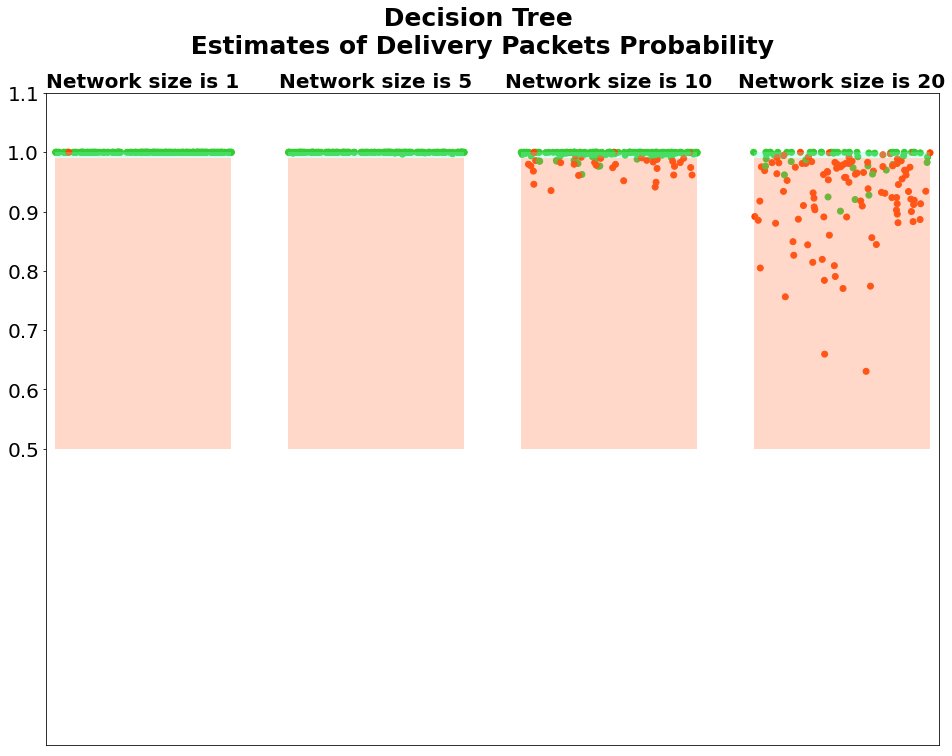

In [147]:
# YLIM = [0, 1]
# net_size = draw_data['NetSize'].unique()
# net_size.sort()
# fig = plt.figure(figsize=(16, 12))
# # fig.suptitle(r'Estimates of Delivery Packets Probability' + 
# #              ' \n $Presicion$ = {}\n $Recall$ = {}\n $F_1$ = {}'.format(
# #                 tree_prob_precision_score, 
# #                 tree_prob_recall_score, 
# #                 tree_prob_f1_score), fontsize=18)
# fig.suptitle(r' Decision Tree' + 
#              ' \n Estimates of Delivery Packets Probability', 
#              fontsize=25,
#              fontweight='bold')
# # plt.subplots_adjust(top=0.92)
# plt.yticks(np.arange(0.5, 1.1, 0.1), fontsize=20)
# plt.xticks([]) 
# k = 1
# for i in net_size:
#     size = [1, 5, 10, 20]
#     if i in size:
#         draw_plot = draw_data.loc[draw_data['NetSize']==i]
#         ax = fig.add_subplot(1, 4,  int(k))

#         plt.title('Network size is ' + str(int(i)), fontsize=20, fontweight='bold')    
#         plt.ylim(YLIM)

#         prob_color = ['limegreen' if i >BOUNDARY else 'orangered' for i in draw_plot['TreeDeliveryProbEst']]
#         ax.scatter(draw_plot['TreeDeliveryProbTest'].index, draw_plot['TreeDeliveryProbTest'], 
#                    color=prob_color)
#         ax.add_patch(
#          patches.Rectangle(
#             (0, 0.5),
#             width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
#             height=BOUNDARY-0.5,
#             facecolor = 'coral',
#             fill=True,
#             alpha=0.3))
#         ax.add_patch(
#          patches.Rectangle(
#             (0, BOUNDARY),
#             width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
#             height=1 - BOUNDARY,
#             facecolor = 'aquamarine',
#             fill=True, alpha=0.3))

#         plt.xticks(color='w')   
#         ax.set_xlabel(r'$Test \ Samples$')
#         ax.set_ylabel(r'$Probability$')
#         k += 1
#         plt.xticks(color='w')
#         plt.yticks(np.arange(0.5, 1.1, 0.1)) 
#         ax.axis('off') 

# plt.savefig('data/m_ph_images/tree_clf_prob.pdf')

- ## Модель задачи классификации на градиентном бустинге с алгоритмом CatBoost

In [148]:
"""Prepare classification model using Cat Boost algorithm"""
def get_catboost_classif_model(x_train, x_test, 
                               y_train, y_test)-> Tuple[np.array, 
                                                        CatBoostClassifier, 
                                                        list, 
                                                        list]: 
    catboost_clf = CatBoostClassifier(iterations=1000,
                                        learning_rate=0.1);
    binary_train = [1 if i > BOUNDARY else 0 for i in y_train]
    binary_test = [1 if i > BOUNDARY else 0 for i in y_test]
    catboost_clf.fit(x_train, binary_train);
    catboost_prob_estimate = catboost_clf.predict(x_test);
    
    return catboost_prob_estimate, catboost_clf, binary_train, binary_test

In [149]:
catboost_prob_estimate, catboost_clf, prob_clf_train, prob_clf_test = get_catboost_classif_model(
    x_train, 
    x_test, 
    y_train['DeliveryProb'], 
    y_test['DeliveryProb'])

catboost_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, catboost_prob_estimate))
catboost_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, catboost_prob_estimate))
catboost_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, catboost_prob_estimate))
print(catboost_prob_precision_score)
print(catboost_prob_recall_score)
print(catboost_prob_f1_score)

0:	learn: 0.5713575	total: 77.9ms	remaining: 1m 17s
1:	learn: 0.4911192	total: 86.2ms	remaining: 43s
2:	learn: 0.4305515	total: 93.9ms	remaining: 31.2s
3:	learn: 0.3817384	total: 99.7ms	remaining: 24.8s
4:	learn: 0.3537661	total: 104ms	remaining: 20.7s
5:	learn: 0.3262584	total: 108ms	remaining: 17.8s
6:	learn: 0.3056929	total: 111ms	remaining: 15.7s
7:	learn: 0.2866082	total: 114ms	remaining: 14.1s
8:	learn: 0.2708861	total: 116ms	remaining: 12.8s
9:	learn: 0.2579511	total: 119ms	remaining: 11.7s
10:	learn: 0.2514405	total: 121ms	remaining: 10.9s
11:	learn: 0.2443166	total: 123ms	remaining: 10.1s
12:	learn: 0.2368399	total: 125ms	remaining: 9.49s
13:	learn: 0.2315963	total: 127ms	remaining: 8.96s
14:	learn: 0.2277944	total: 129ms	remaining: 8.49s
15:	learn: 0.2226465	total: 132ms	remaining: 8.09s
16:	learn: 0.2198268	total: 134ms	remaining: 7.74s
17:	learn: 0.2172729	total: 136ms	remaining: 7.41s
18:	learn: 0.2142764	total: 138ms	remaining: 7.1s
19:	learn: 0.2111626	total: 139ms	remai

195:	learn: 0.1273845	total: 469ms	remaining: 1.92s
196:	learn: 0.1269963	total: 471ms	remaining: 1.92s
197:	learn: 0.1268057	total: 472ms	remaining: 1.91s
198:	learn: 0.1265457	total: 474ms	remaining: 1.91s
199:	learn: 0.1262705	total: 476ms	remaining: 1.9s
200:	learn: 0.1258432	total: 478ms	remaining: 1.9s
201:	learn: 0.1255846	total: 480ms	remaining: 1.89s
202:	learn: 0.1251257	total: 482ms	remaining: 1.89s
203:	learn: 0.1248773	total: 483ms	remaining: 1.89s
204:	learn: 0.1247295	total: 485ms	remaining: 1.88s
205:	learn: 0.1243509	total: 488ms	remaining: 1.88s
206:	learn: 0.1241542	total: 490ms	remaining: 1.88s
207:	learn: 0.1237840	total: 492ms	remaining: 1.87s
208:	learn: 0.1235560	total: 494ms	remaining: 1.87s
209:	learn: 0.1233608	total: 496ms	remaining: 1.87s
210:	learn: 0.1231826	total: 498ms	remaining: 1.86s
211:	learn: 0.1229129	total: 500ms	remaining: 1.86s
212:	learn: 0.1227042	total: 502ms	remaining: 1.85s
213:	learn: 0.1225886	total: 503ms	remaining: 1.85s
214:	learn: 0.

393:	learn: 0.0854736	total: 855ms	remaining: 1.31s
394:	learn: 0.0853556	total: 858ms	remaining: 1.31s
395:	learn: 0.0852352	total: 860ms	remaining: 1.31s
396:	learn: 0.0851450	total: 863ms	remaining: 1.31s
397:	learn: 0.0849730	total: 865ms	remaining: 1.31s
398:	learn: 0.0848232	total: 867ms	remaining: 1.31s
399:	learn: 0.0846188	total: 869ms	remaining: 1.3s
400:	learn: 0.0844501	total: 871ms	remaining: 1.3s
401:	learn: 0.0843202	total: 873ms	remaining: 1.3s
402:	learn: 0.0841477	total: 875ms	remaining: 1.3s
403:	learn: 0.0839258	total: 877ms	remaining: 1.29s
404:	learn: 0.0837895	total: 879ms	remaining: 1.29s
405:	learn: 0.0834879	total: 883ms	remaining: 1.29s
406:	learn: 0.0833627	total: 885ms	remaining: 1.29s
407:	learn: 0.0831290	total: 887ms	remaining: 1.29s
408:	learn: 0.0829294	total: 889ms	remaining: 1.28s
409:	learn: 0.0827410	total: 891ms	remaining: 1.28s
410:	learn: 0.0826427	total: 893ms	remaining: 1.28s
411:	learn: 0.0824708	total: 895ms	remaining: 1.28s
412:	learn: 0.08

572:	learn: 0.0637395	total: 1.24s	remaining: 925ms
573:	learn: 0.0635827	total: 1.24s	remaining: 923ms
574:	learn: 0.0635239	total: 1.25s	remaining: 921ms
575:	learn: 0.0633835	total: 1.25s	remaining: 919ms
576:	learn: 0.0632581	total: 1.25s	remaining: 916ms
577:	learn: 0.0631768	total: 1.25s	remaining: 914ms
578:	learn: 0.0630691	total: 1.25s	remaining: 912ms
579:	learn: 0.0629850	total: 1.26s	remaining: 910ms
580:	learn: 0.0629103	total: 1.26s	remaining: 908ms
581:	learn: 0.0627607	total: 1.26s	remaining: 906ms
582:	learn: 0.0626210	total: 1.26s	remaining: 903ms
583:	learn: 0.0625149	total: 1.27s	remaining: 907ms
584:	learn: 0.0623697	total: 1.27s	remaining: 905ms
585:	learn: 0.0622507	total: 1.28s	remaining: 903ms
586:	learn: 0.0621632	total: 1.28s	remaining: 900ms
587:	learn: 0.0620504	total: 1.28s	remaining: 898ms
588:	learn: 0.0619332	total: 1.28s	remaining: 896ms
589:	learn: 0.0617875	total: 1.28s	remaining: 893ms
590:	learn: 0.0616838	total: 1.29s	remaining: 891ms
591:	learn: 

782:	learn: 0.0466653	total: 1.63s	remaining: 453ms
783:	learn: 0.0465924	total: 1.64s	remaining: 451ms
784:	learn: 0.0465189	total: 1.64s	remaining: 448ms
785:	learn: 0.0465005	total: 1.64s	remaining: 446ms
786:	learn: 0.0464591	total: 1.64s	remaining: 444ms
787:	learn: 0.0464256	total: 1.64s	remaining: 442ms
788:	learn: 0.0463585	total: 1.64s	remaining: 440ms
789:	learn: 0.0462921	total: 1.65s	remaining: 438ms
790:	learn: 0.0462425	total: 1.65s	remaining: 435ms
791:	learn: 0.0461237	total: 1.65s	remaining: 433ms
792:	learn: 0.0460713	total: 1.65s	remaining: 431ms
793:	learn: 0.0459255	total: 1.65s	remaining: 429ms
794:	learn: 0.0458661	total: 1.66s	remaining: 427ms
795:	learn: 0.0457638	total: 1.66s	remaining: 425ms
796:	learn: 0.0456996	total: 1.66s	remaining: 423ms
797:	learn: 0.0456620	total: 1.66s	remaining: 420ms
798:	learn: 0.0455831	total: 1.66s	remaining: 418ms
799:	learn: 0.0455121	total: 1.66s	remaining: 416ms
800:	learn: 0.0454531	total: 1.67s	remaining: 414ms
801:	learn: 

0.944
0.943
0.943


In [150]:
draw_data['CatBoostProbEst'] = catboost_prob_estimate

- ## Модель задачи классификации c помощью логистической регрессии

In [151]:
"""Prepare classification model using Logistic Regression algorithm"""
def get_logress_classif_model(x_train, x_test, 
                              y_train, y_test,
                              boundary=0.9)-> Tuple[np.array, LogisticRegression,
                                                    list, list]: 
    logres_model = LogisticRegression(max_iter=1000)
    binary_train = [1 if i > boundary else 0 for i in y_train]
    binary_test = [1 if i > boundary else 0 for i in y_test]
    logres_model.fit(x_train, binary_train)
    logres_prob_estimate = logres_model.predict(x_test)
    
    return logres_prob_estimate, logres_model, binary_train, binary_test

In [152]:
logres_prob_estimate, logres_model, prob_clf_train, prob_clf_test = get_logress_classif_model(x_train, 
                                                                                x_test, 
                                                                                y_train['DeliveryProb'], 
                                                                                y_test['DeliveryProb'],
                                                                                boundary=BOUNDARY)

logres_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, logres_prob_estimate))
logres_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, logres_prob_estimate))
logres_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, logres_prob_estimate))
print(logres_prob_precision_score)
print(logres_prob_recall_score)
print(logres_prob_f1_score)

0.890
0.923
0.907


In [153]:
draw_data['LogResProbEst'] = logres_prob_estimate

In [ ]:
COLUMNS = (
    'ArrM1',
    'ArrAvg',
    'SrvM1',
    'SrvM2',
    'SrvM3',
    'SrvAvg', 
    'SrvStd', 
    'SrvCv',
    'SrvSkewness', 
    'Rho', 
    'NetSize', 
    'Capacity', 
    'NumPackets',
    'DelayAvg', 
    'DelayStd', 
    'DeliveryProb',
)

arr_m1 = [np.random.uniform(0, 10)]
arr_cv = [np.random.uniform(0.5, 3)]

rho =  np.arange(0.1, 1, 0.05)

srv_cv = [np.random.uniform(0.5, 3)]

net_size = np.arange(1, 20+1)
capacity = [500]
